In [2]:
import torch
import torch.nn as nn
import json
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from configs.dataloaders import create_data_loaders
from runner_static import static_training
from runner_dynamic import dynamic_training
from models.static_models.static_model_multibranch import StaticModelMultibranch

# Static Model

In [3]:
# Initialize random seed
seed = 30026
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Define dimensions of the problem
num_classes = 15
num_timesteps = 5
num_features = 34 # both static and dynamic

# Decide whever to be verbose with display outputs and set device
verbose = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define hyperparameters
with open('hyperparameters.json', 'r') as file:
    params = json.load(file)

static_params = params["static_model"]
dynamic_params = params["dynamic_model"]

# Set embedding dimensions based on json parameter
if static_params["long_embeddings"]:
    embedding_dim = 640
else:
    embedding_dim = 320

# Load file
data = pd.read_csv(params["file_path"])

In [5]:
# Split dataset in train and test sets keeping balance for the static label localization
data_train, data_test = train_test_split(data, test_size=params["test_size"], random_state=seed, stratify = data['static_localization'])

# Create dataloaders
dataloader_train, dataloader_test = create_data_loaders(data_train, data_test, params["batch_size"])

[0]	train-mlogloss:2.70639	train-merror:0.50000	test-mlogloss:2.70654	test-merror:0.62500


[25]	train-mlogloss:2.66266	train-merror:0.40625	test-mlogloss:2.68060	test-merror:0.50000
[50]	train-mlogloss:2.62270	train-merror:0.40625	test-mlogloss:2.65825	test-merror:0.53125
[75]	train-mlogloss:2.58416	train-merror:0.40625	test-mlogloss:2.63811	test-merror:0.56250
[100]	train-mlogloss:2.54736	train-merror:0.40625	test-mlogloss:2.62039	test-merror:0.56250
[125]	train-mlogloss:2.51372	train-merror:0.40625	test-mlogloss:2.60195	test-merror:0.56250
[150]	train-mlogloss:2.48102	train-merror:0.40625	test-mlogloss:2.58591	test-merror:0.56250
[175]	train-mlogloss:2.44841	train-merror:0.40625	test-mlogloss:2.57087	test-merror:0.56250
[200]	train-mlogloss:2.41731	train-merror:0.40625	test-mlogloss:2.55721	test-merror:0.56250
[225]	train-mlogloss:2.38927	train-merror:0.40625	test-mlogloss:2.54212	test-merror:0.56250
[250]	train-mlogloss:2.36178	train-merror:0.40625	test-mlogloss:2.52967	test-merror:0.56250
[275]	train-mlogloss:2.33555	train-merror:0.40625	test-mlogloss:2.51628	test-merror

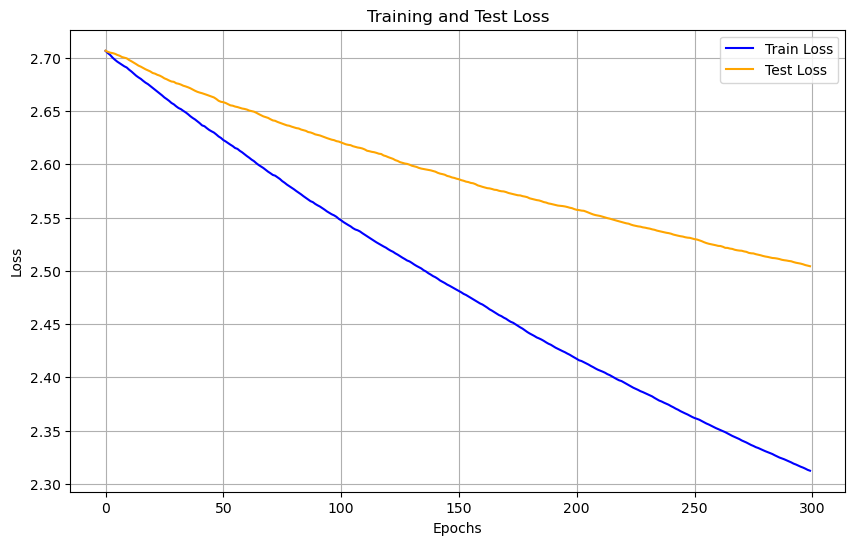

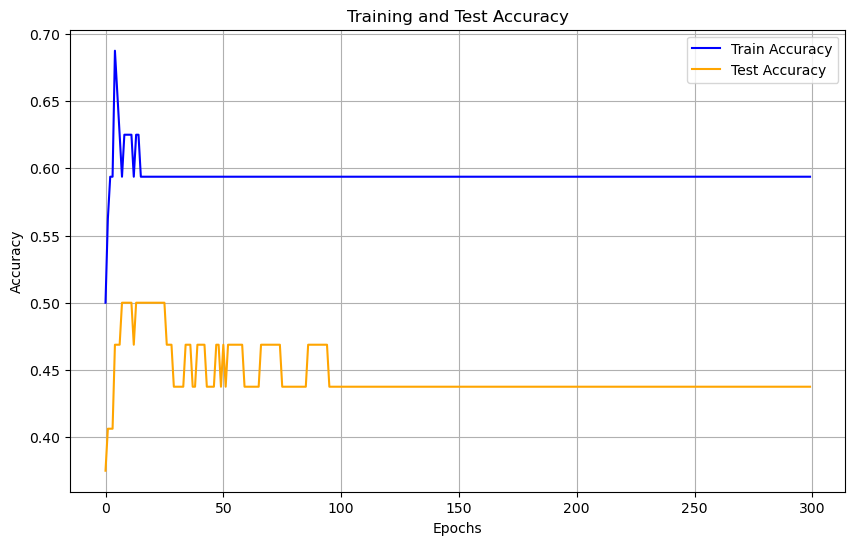

In [8]:
train_loss, train_accuracy, test_loss, test_accuracy, static_model_dict = static_training(num_classes, static_params, dataloader_train, dataloader_test, verbose, device, seed)

In [6]:
# Create a new instance of MarioModel
static_model = StaticModelMultibranch(num_classes=num_classes, embedding_dim=embedding_dim, extremities_dim=20, char_vocab_size=20, char_embed_dim=16, intermediate_dim=static_params["intermediate_dim"], dropout=static_params["dropout"])

# Load the weights from the dictionary
static_model.load_state_dict(static_model_dict)


<All keys matched successfully>

Epoch [1/4],	Training Loss: 2.0372, Training accuracy: 34.47,	Test Loss: 1.8263, Test Accuracy: 35.40,	Learning rate: 0.00100
Epoch [2/4],	Training Loss: 1.7518, Training accuracy: 39.08,	Test Loss: 1.7130, Test Accuracy: 40.54,	Learning rate: 0.00100
Epoch [3/4],	Training Loss: 1.6542, Training accuracy: 43.55,	Test Loss: 1.6440, Test Accuracy: 42.20,	Learning rate: 0.00100
Epoch [4/4],	Training Loss: 1.5844, Training accuracy: 46.79,	Test Loss: 1.5877, Test Accuracy: 45.16,	Learning rate: 0.00100


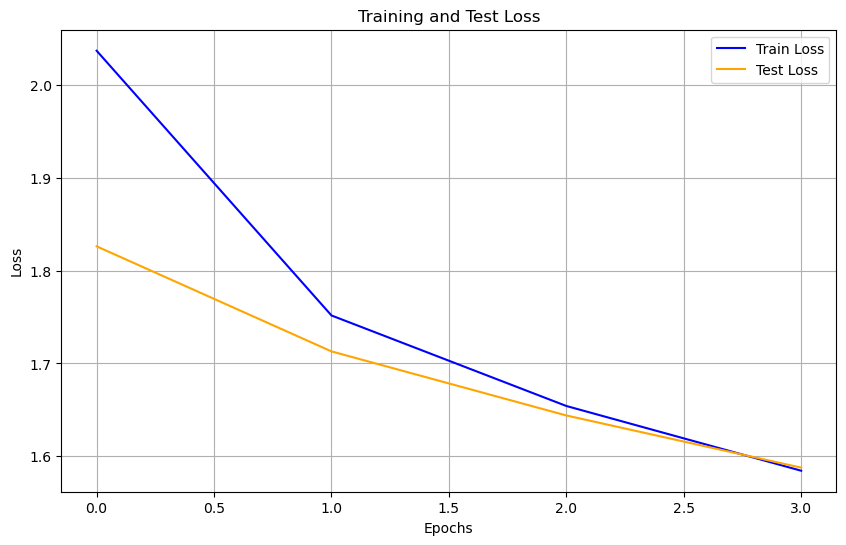

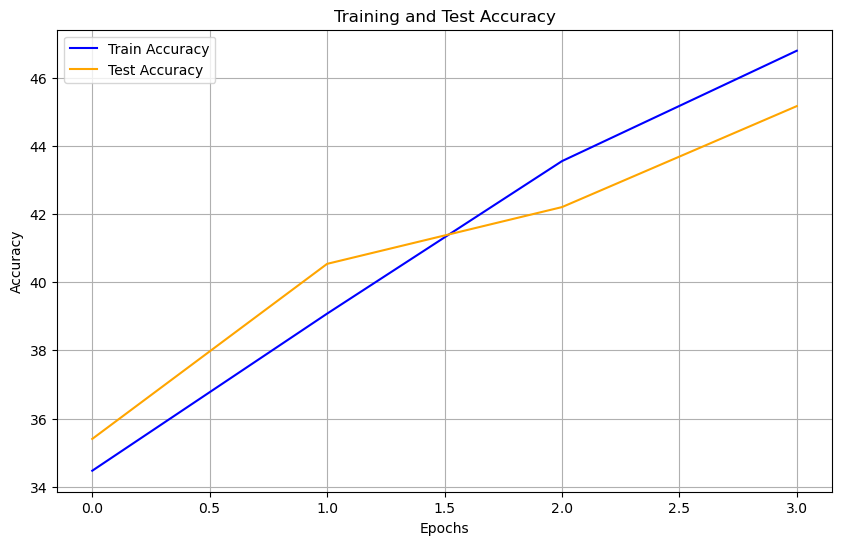

In [7]:
train_loss, train_accuracy, test_loss, test_accuracy, dynamic_model = dynamic_training(num_features, num_classes, num_timesteps, embedding_dim, dynamic_params, static_model, dataloader_train, dataloader_test, verbose, device, seed)